In [1]:
import numpy as np
import itertools as it
from mds.mds import mds
from mds.rotation3sphere import cartesian_to_hyperspherical
from hopf.hopf import localcoordsampling_2sphere, hopf_fibration_inverse
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from mds.visualizationtools import add_axis_cube

**IDEA:**
<br>$(S^3,S^2,\pi,S^1)$ is a fiber bundle, where $\pi : S^3 \to S^2$ being the Hopf
fibration, and for every $p\in S^2, \pi^{-1}(p)=S^1$. What this essentially
means is that $S^3$ is all the possible combinations of the fiber corresponding
to each point in $S^2$. Therefore, if we are able to measure distances in $S^2$
in terms of how similar the induced fibers are, we can draw the points in $S^2$
accordingly and have a first idea of the structure of $S^3$.

- Sampling points from $S^2$ uniformly: We can use the Fibonacci sampling 
- For each of these points, we need to sample points from their corresponding fiber
(the same amount for each point) 
- Between every two points of $S^2$ that we sampled, compute the distance between 
the corresponding fibers (registration distance). For this, we need to solve: 
<br>A*=$\underset{A}{\min}\langle C, A \rangle$, such that $A\mathbf{1}_{n}=\mathbf{1}_{n}, \ A^{\top}\mathbf{1}_{n}=\mathbf{1}_{n}$
where $C\in\mathbb{R}^{n\times n}$ contains the pairwise distances between points 
on the fibers.
<br>The optimal $A$ is a permutation which registers both sets of fiber points.
The registration distance is then $d_\mathrm{fibers} = \langle C,A^*\rangle$.

- Figure out a meaningful combination distance for the final merging + visualization.
<br>$d_\mathrm{total}(p,q)=\sqrt{(1-\alpha)d_\mathrm{geod}^2(p,q)+\alpha d_\mathrm{fibers}^2(p,q)}$
<br> We need to figure out how much more/less important is the similarity of the fibers compared to the geodesic distance between points in the base manifold.
Also, the different orders of magnitude in $d_\mathrm{geod}$ and $d_\mathrm{fibers}$ should be accounted for.

- Visualization: mds into $\mathbb{R}^3$ with distance matrix constructed using the distance $d_\mathrm{total}$

In [2]:
def distance_matrix_regist(p1, p2, hyperspherical=False):
    """Build the matrix of distances for calculation of the registration distance.
    Note that this matrix is not symmetrical.
    
    p1: vector of points from first fiber
    p2: vector of points from second fiber
    hyperspherical: Boolean setting whether points are in hyperspherical or cartesian coordinates
    """
    mat = np.zeros((len(p1),)*2)
    if hyperspherical:
        for i in range(len(p1)):
            for j in range(len(p1)):
                # this subtraction gives a new point j' whose distance can be calculated to i' = north pole
                angle_diff = p2[j] - p1[i]
                # this uses the expressions for the first and two elements of a point as given in mds.hyperspherical_to_cartesian
                mat[i,j] = np.abs(np.arccos(np.exp(1j*angle_diff[0]) + 1j*np.cos(angle_diff[1])))
    else:
        for i in range(len(points)):
            for j in range(len(points)):
                mat[i,j] = distance(p1[i], p2[j])
    return mat

In [3]:
def registration_distance(fiber1, fiber2, hyperspherical=False):
    C = distance_matrix_regist(fiber1, fiber2, hyperspherical=hyperspherical)
    row_ind, col_ind = linear_sum_assignment(C)
    return C[row_ind, col_ind].sum()

In [4]:
def geodesic_distance_s2(p1, p2):
    """
    Compute the great-circle (geodesic) distance between two points on S2.
    
    Parameters:
    - p1 = (theta1, phi1): Spherical coordinates of the first point (colatitude, longitude)
    - p2 = (theta2, phi2): Spherical coordinates of the second point (colatitude, longitude)
    
    Returns:
    - Geodesic distance between the two points
    """
    theta1, phi1 = p1
    theta1 -= np.pi/2
    theta2, phi2 = p2
    theta2 -= np.pi/2
    inner_product = np.sin(theta1) * np.sin(theta2) + np.cos(theta1) * np.cos(theta2) * np.cos(phi1 - phi2)
    return np.arccos(inner_product)

In [5]:
def modified_distance_s2(p1, p2, alpha=0.5, n_fiber_points=30, hyperspherical=False):
    _, sampled_fiber1 = hopf_fibration_inverse([p1], n_fiber_points, hyperspherical=hyperspherical)[0]
    _, sampled_fiber2 = hopf_fibration_inverse([p2], n_fiber_points, hyperspherical=hyperspherical)[0]
    d_regis = registration_distance(sampled_fiber1, sampled_fiber2, hyperspherical=hyperspherical)
    d_geod = geodesic_distance_s2(p1, p2)

    return np.sqrt((1-alpha)*d_geod**2 + alpha * d_regis**2)

In [6]:
def scatter_3d(x, y, z, title="3D scatter plot"):
    """Plot the 3D points outputted by MDS."""
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d', box_aspect=(1,1,1))
    ax.scatter(x, y, z, c='b', marker='o')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(title)

    plt.show()

# Examples

First, MDS with the previously defined modified distance is run on the points.

In [7]:
points = np.array(localcoordsampling_2sphere(250))
x, y, z = mds(points, 3, distance=modified_distance_s2, alpha=0.03, hyperspherical=True)

There are 250 eigenvalues.
Number of large, non-zero eigenvalues for approximate embedding: 238 (95.20%)


Note the small value $\alpha = 0.03$.
From experience, the magnitude of geodesic distances is $10^0$, while the magnitude of registration distances is $10^1$.
Thus, to give a roughly equitable contribution of both distances, it is necessary that $\alpha$ be small to adjust for this imbalance.

## Unconnected points

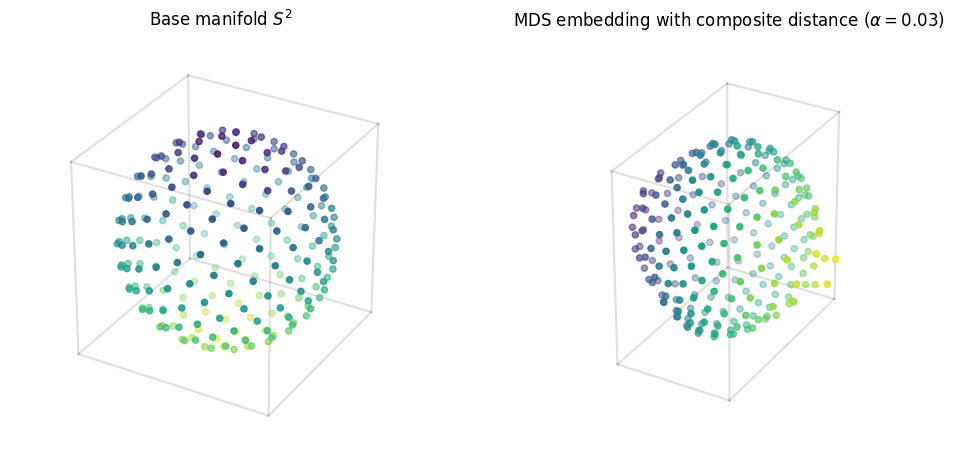

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12,8), subplot_kw={"projection": '3d', "box_aspect": (1,1,1)})
ax = axes[0]
base_points = zip(*[ (np.sin(θ)*np.cos(φ), np.sin(θ)*np.sin(φ), np.cos(θ)) for θ, φ in points ])
colors = cm.viridis(points[:,0]/np.pi)

ax.scatter(*base_points, c=colors)
ax.set_axis_off()

add_axis_cube(ax, 2)
ax.set_title("Base manifold $S^2$")

ax = axes[1]
ax.scatter(x, y, z, c=colors, marker='o')

add_axis_cube(ax, 3)
ax.set_axis_off()

ax.set_title("MDS embedding with composite distance ($\\alpha = 0.03$)")
plt.savefig("basemanifoldangles.png", bbox_inches='tight')
plt.show()

## Connected points

This might be an alternative visualization: The nearest neighbours on $S^2$ (base manifold) are shown connected, so that this structure is visible as well.
Colours are retained for additional information, their presence should not hurt the interpretability.

In [9]:
def find_closest_neighbour_edges(points, n_neighbours):
    """Find the n closest neighbours for each point (by geodesic distance) and give the corresponding edges."""
    n_points = len(points)
    edges = []
    # to account for edges (i,j) and (j,i) being equivalent
    edge_order = lambda x: x if x[0]<x[1] else (x[1],x[0])
    edge_same = lambda x: x[0] != x[1]
    
    for i in range(n_points):
        sorted_neighbours = sorted( range(n_points), key=lambda j: (geodesic_distance_s2(points[i], points[j]) if i!=j else 0) )
        edges += list(filter(edge_same, zip(it.repeat(i), sorted_neighbours)))[:n_neighbours]
    edges = list(map(edge_order, edges))
    
    edges_uniq, _ = zip(*it.groupby(sorted(edges)))

    return edges_uniq

def draw_edges(axis, points, edges, edgecolors, alpha=0.6):
    """Draw all edges (pairs of indices into points) into axis."""
    for edge, color in zip(edges, edgecolors):
        axis.plot(*points[edge,].T, color=color, linestyle='-', alpha=alpha)

In [10]:
n_neighbours = 4

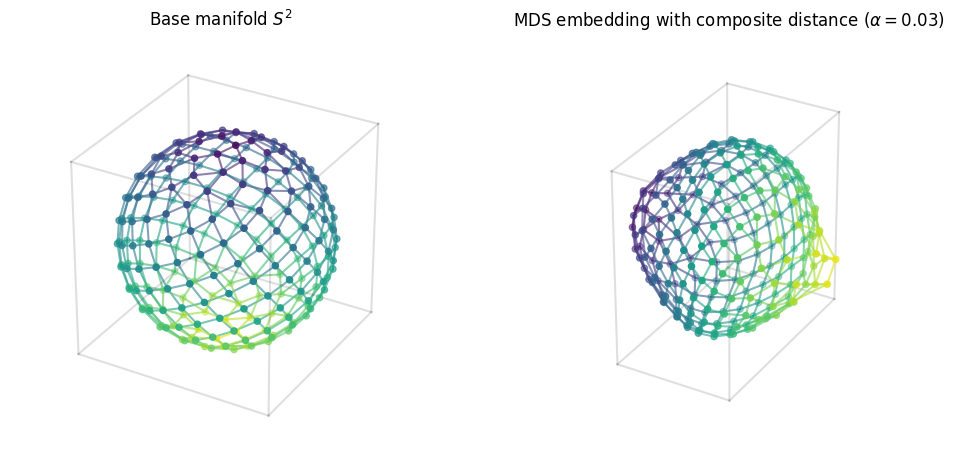

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12,8), subplot_kw={"projection": '3d', "box_aspect": (1,1,1)})
ax = axes[0]
base_points = np.array([ (np.sin(θ)*np.cos(φ), np.sin(θ)*np.sin(φ), np.cos(θ)) for θ, φ in points ])
colors = cm.viridis(points[:,0]/np.pi)
neighbour_edges = find_closest_neighbour_edges(points, n_neighbours)
edges_colors = cm.viridis(points[np.array(list(map(lambda x: x[0], neighbour_edges))),0]/np.pi)

draw_edges(ax, base_points, neighbour_edges, edges_colors)
ax.scatter(*base_points.T, c=colors)
ax.set_axis_off()

add_axis_cube(ax, 2)
ax.set_title("Base manifold $S^2$")

ax = axes[1]
ax.scatter(x, y, z, c=colors, marker='o')

add_axis_cube(ax, 3)
draw_edges(ax, np.array(list(zip(x,y,z))), neighbour_edges, edges_colors)
ax.set_axis_off()

ax.set_title("MDS embedding with composite distance ($\\alpha = 0.03$)")
plt.savefig("basemanifoldangles-connected.png", bbox_inches='tight')
plt.show()